In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support
from scipy.special import expit
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import mode
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
import wandb
from sklearn.model_selection import KFold


In [3]:
class MyDecisionTreeClassifier:
    def __init__(self, **kwargs):
        """
        Initialize the Decision Tree Classifier.

        Parameters:
        - **kwargs: Any additional arguments accepted by DecisionTreeClassifier
        """
        self.model = DecisionTreeClassifier(**kwargs)

    def fit(self, X_train, y_train):
        """
        Fit the Decision Tree Classifier to the training data.

        Parameters:
        - X_train: Training features
        - y_train: Training labels
        """
        self.model.fit(X_train, y_train)

    def validate(self,X_val, y_val):
        predictions = self.model.predict(X_val)
        accuracy = accuracy_score(y_val, predictions)
        return accuracy

    
    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions
    
    def getClassificationReport(self, y_true, y_pred):
        self.report = classification_report(y_pred,y_true,zero_division=1)
        return self.report
    



In [4]:
class AdaBoost:
    def __init__(self,num_estimators,f):
        self.num_est = num_estimators
        self.train_fraction = f
        self.models = []
        self.errors = []
        
        
    def initialize_weights(self, X_train):
        num_samples = X_train.shape[0]
        self.weights = np.ones(num_samples)
        self.weights = self.weights/num_samples
        
    def get_sampled_train_data(self, X_train,y_train, f):
        num_samples = int(X_train.shape[0] * f)
        
        # Randomly choose indices based on the probability distribution
        chosen_indices = np.random.choice(X_train.shape[0], size=num_samples, replace=False, p=self.weights/np.sum(self.weights))

        # Extract the corresponding samples from X_train and y_train
        X = X_train[chosen_indices]
        y = y_train[chosen_indices]
        
        return X,y
    
    def calculate_performance(self,e):
        if e>0.5:
            e=e-(1e-6)
        else:
            e=e+(1e-6)
        alpha = 0.5*np.log((1-e)/e)
        return alpha
    
    def update_weights(self,alpha,ind):
        adjusted_weights = np.copy(self.weights)
        adjusted_weights[ind] *= np.exp(alpha)
        ind0 = np.setdiff1d(np.arange(len(self.weights)), ind)
        adjusted_weights[ind0] *= np.exp(-alpha)
        self.weights = adjusted_weights/np.sum(adjusted_weights)


    def fit(self,X_train, y_train):
        self.initialize_weights(X_train)
        
        for i in range(self.num_est):
            dt = MyDecisionTreeClassifier(max_depth=2)
            X,y = self.get_sampled_train_data(X_train,y_train,self.train_fraction)
            dt.fit(X,y)
            y_pred = dt.predict(X_train)
            self.models.append(dt)
            
            misclassified_indices = np.where(y_pred != y_train)[0]
            total_error = np.sum(self.weights[misclassified_indices])
            alpha = self.calculate_performance(total_error)
            self.update_weights(alpha,misclassified_indices)
            self.errors.append(alpha)
        
    def predict(self,X_test):
        
        predictions = np.zeros(X_test.shape[0])
        sum = 0
        for i in range(self.num_est):
            model = self.models[i]
            y_pred = model.predict(X_test)
            y_pred = y_pred*self.errors[i]
            predictions = predictions + y_pred
            sum = sum + self.errors[i]
        predictions /= sum
        return predictions>0.5
            

##  Adaboost with Decision Trees (Classification)

In [5]:
# loading the data
file_path = './WineQT.csv'

data = pd.read_csv(file_path)
df = pd.DataFrame(data)
df = df.drop(df.columns[-1], axis=1)
labels = df.columns.tolist()

num_features = df.shape[1]-1
num_classes = df.iloc[:, -1].nunique()

X = df.iloc[:, :-1].values
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
X = (X - mean) / std


f=0.8

y = df.iloc[:, -1].values
y = y - 3

y = y/5
y = np.where(y<0.5,0,1)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=1-f, random_state=42)
# then splitting the remaining data into val and test (50% each)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [6]:
adb = AdaBoost(num_estimators=5,f=0.7)

In [7]:
adb.fit(X_train,y_train)

In [8]:
y_pred = adb.predict(X_test)
print('Predicted : ',y_pred)
print('Actual : ',y_test)

print('Accuracy : ',np.sum(y_pred==y_test)/y_test.shape[0])

Predicted :  [ True  True False  True False  True False  True  True  True  True  True
 False  True False False  True  True False False  True  True False  True
  True False False  True False False False False False False  True  True
  True False  True  True False  True False  True  True False  True  True
 False  True  True  True False  True False False  True  True  True False
 False  True  True  True False False False False False  True False False
  True  True False False False False  True False  True False  True False
 False  True False  True  True  True False  True  True False False  True
  True  True  True False False  True False  True False False  True False
  True False  True  True  True  True  True]
Actual :  [1 1 0 1 1 1 0 0 1 1 1 1 1 0 0 1 0 1 0 0 1 1 0 1 1 0 0 1 0 1 0 0 1 0 0 1 0
 0 0 1 0 1 0 1 0 0 1 1 0 0 0 1 0 1 1 0 1 1 1 1 0 0 1 1 0 1 0 0 0 1 1 1 1 1
 1 1 1 0 1 1 0 0 1 0 0 1 0 1 1 0 0 1 1 0 0 1 1 0 1 0 0 0 1 1 0 0 1 0 1 0 1
 1 1 0 1]
Accuracy :  0.7391304347826086


In [9]:
acc_list = []
inf_time = []
num_est = []

for n in range(100):
    adb = AdaBoost(num_estimators=n+5,f=0.7)
    t1 = time.time()
    adb.fit(X_train,y_train)
    t2 = time.time()
    y_pred = adb.predict(X_test)
    acc = np.sum(y_pred==y_test)/y_test.shape[0]
    
    num_est.append(n+5)
    acc_list.append(acc)
    inf_time.append(t2-t1)
    


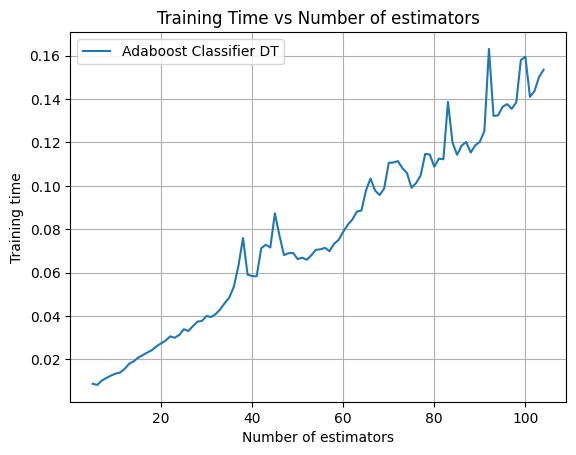

In [10]:
plt.plot(num_est, inf_time, label='Adaboost Classifier DT')
plt.xlabel('Number of estimators')
plt.ylabel('Training time')
plt.legend()
plt.grid()
plt.title('Training Time vs Number of estimators')
plt.show()

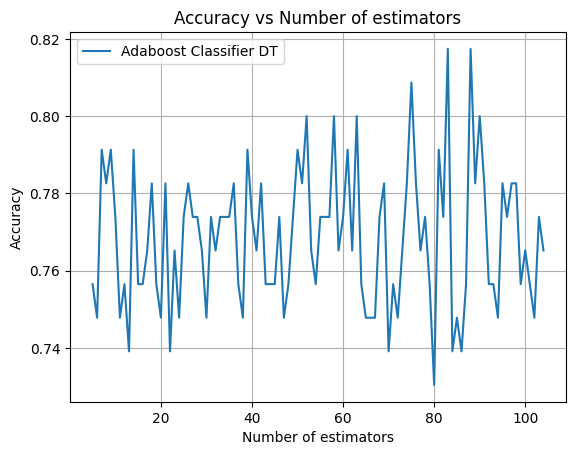

In [11]:
plt.plot(num_est, acc_list, label='Adaboost Classifier DT')
plt.xlabel('Number of estimators')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy vs Number of estimators')
plt.show()